In [1]:
%load_ext autoreload
%autoreload 2
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
# Optional; can help when memory is tight.
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [110]:
from IPython.display import display, HTML, Markdown

def generate(model, tokenizer, prompt):
    input_string = prompt
    inputs = tokenizer(input_string, return_tensors="pt", return_attention_mask=True).to('cuda')
    
    outputs = model.generate(**inputs, max_new_tokens=50)
    text = tokenizer.batch_decode(outputs)[0][len(input_string):]

    display(HTML(f"<pre>{input_string}</pre><pre style='background-color: rgb(200, 255, 200, 1.0)'>{text}<pre>"))

    return inputs, outputs, text

def run_coding_sample(model, tokenizer):
    prompt = '''def print_prime(n):
       """
       Print all primes between 1 and n
       """'''
    return generate(model, tokenizer, prompt)

def run_coding_sample_2(model, tokenizer):
    prompt = '''def array_sum(array, nrows, ncols):
       """
       Use two for loops to add elements of an array.
       """'''
    return generate(model, tokenizer, prompt)

In [33]:
from hooked_phi import attach_hooks, detach_hooks

# Returns a hook that can be used to ablate a set of neurons.
def ablate_neurons(mask):
    assert mask.shape[0] == model.config.num_hidden_layers
    assert mask.shape[1] == model.config.intermediate_size

    def hook(neurons, layer_idx):
        neurons[..., ~mask[layer_idx]] = 0
        return neurons

    return hook

# Ablate the last layer MLP.
for num_ablation_layers in range(0, 9, 2):
    display(Markdown(f'# Zeroing-out intermediate layers of the last {num_ablation_layers} MLPs'))
    
    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    if num_ablation_layers > 0:
        mask[-num_ablation_layers:, :] = False
    
    attach_hooks(model.model, ablate_neurons(mask))
    # detach_hooks(model.model)
    
    # Post-ablation
    run_coding_sample(model, tokenizer)

detach_hooks(model.model)

# Zeroing-out intermediate layers of the last 0 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 2 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 4 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 6 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 8 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Viewing "kernel" of MLP intermediate states

If there MLP intermediate states represent recall coefficients - with the MLP encoder representing detection, and the MLP decoder representing triggering of the new memory - we would expect that most MLP intermediate states would be 0 (as only a sparse number of "memories" should be activated at any given time), or that MLP intermediate states would be correlated with meaningful concepts. Let's test this hypothesis.

In [45]:
def log_neurons(neurons, layer_idx):
    if layer_idx == 0:
        log.append([])

    log[-1].append(neurons)
    
    return neurons

attach_hooks(model.model, log_neurons)

In [114]:
log = []
inputs, outputs, text = run_coding_sample_2(model, tokenizer)

layer_id = 0

all_mlp_activations = []
for i in range(len(log)):
    # log[forward pass index][layer index][batch index, token index in forward pass, mlp neuron index]
    mlp_activations = log[i][layer_id][0, -1, :]
    all_mlp_activations.append(mlp_activations)

stacked = torch.stack(all_mlp_activations, dim=0)

# Scale each MLP intermediate neuron by the maximum absolute value
scale_by_dim = torch.max(stacked.abs(), dim=0, keepdims=True).values
stacked_scaled = stacked / (scale_by_dim + 1e-5)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


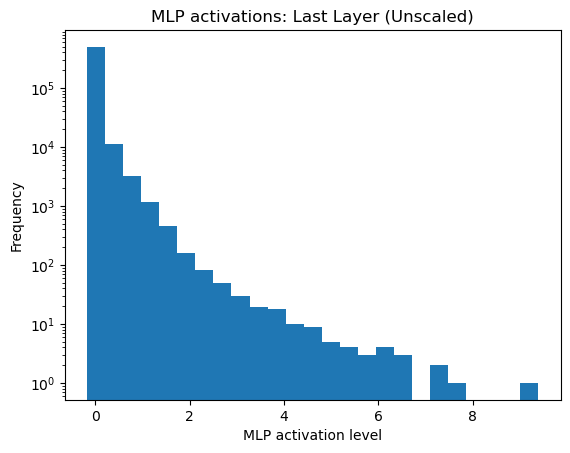

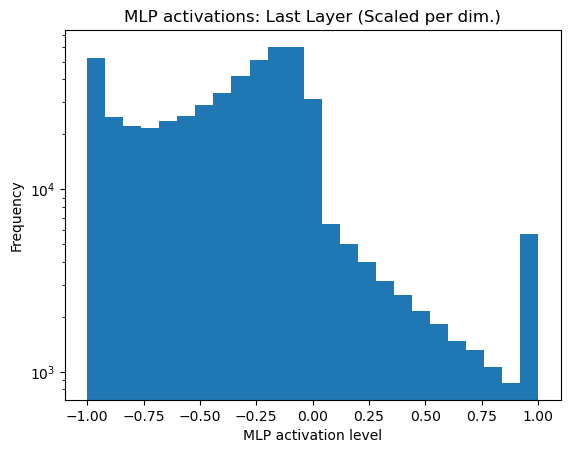

In [112]:
import matplotlib.pyplot as plt

plt.title("MLP activations: Last Layer (Unscaled)")
plt.hist(stacked.view(-1).cpu(), bins=25)
plt.xlabel("MLP activation level")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()

plt.title("MLP activations: Last Layer (Scaled per dim.)")
plt.hist(stacked_scaled.view(-1).cpu(), bins=25)
plt.xlabel("MLP activation level")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()

## Interpretation

It seems that MLP activations are very sparse. Therefore, it will hopefully be relatively simple to find meaningful MLP neurons to visualize.

To automatically determine which MLP activations are most interesting, I will calculate the variance of the activations.


In [115]:
from neuron_visualization import basic_neuron_vis

variance = stacked.var(dim=0)
highest_to_lowest_variance = variance.argsort(descending=True)
visualized_tokens = outputs[0].cpu()[len(inputs['input_ids'][0].cpu()):]

token_names = [
    tokenizer.decode(torch.tensor([visualized_tokens[i]]))
    for i in range(len(visualized_tokens))
]

visualized_neurons = highest_to_lowest_variance[:100]

for neuron_i in range(len(visualized_neurons)):
    neuron_id = visualized_neurons[neuron_i]
    html = basic_neuron_vis(token_names, stacked[:, neuron_id], layer=layer_id, neuron_index=neuron_id)
    display(HTML(html))
